In [1]:
import numpy as np
import itertools
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
from scipy.stats import linregress

from bamf.bamfCR import *

import time

# set plot parameters
params = {'legend.fontsize': 18,
          'figure.figsize': (8, 7),
          'axes.labelsize': 24,
          'axes.titlesize':24,
          'axes.linewidth':3,
          'xtick.labelsize':20,
          'ytick.labelsize':20}
plt.rcParams.update(params)
plt.style.use('seaborn-colorblind')
plt.rcParams['pdf.fonttype'] = 42

np.random.seed(12345)



<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


# Import data

In [2]:
# used later for model validation
gLV_data = pd.read_csv("gLV_data/MS008_processed_mono.csv")
gLV_data.head()

,Treatments,Time,CA,BT,BU,CS,CD,DP,CH,BV
0,MS008-BT,0.0,0.0,0.00500,0.000000,0.0,0.005000,0.0,0.0,0.0
1,MS008-BT,12.0,0.0,1.08115,0.000000,0.0,0.337850,0.0,0.0,0.0
2,MS008-BT,24.0,0.0,0.96386,0.000000,0.0,0.202807,0.0,0.0,0.0
3,MS008-BU,0.0,0.0,0.00000,0.005000,0.0,0.005000,0.0,0.0,0.0
4,MS008-BU,12.0,0.0,0.00000,0.455992,0.0,0.565842,0.0,0.0,0.0


In [3]:
species = ['BU']
BT_data = gLV_data.iloc[np.in1d(gLV_data.Treatments.values, [f"Monoculture{sp}" for sp in species])]
BT_data = BT_data[["Treatments", "Time"] + species]
BT_data

,Treatments,Time,BU
200,MonocultureBU,0.0,0.023300
201,MonocultureBU,3.0,0.095600
202,MonocultureBU,6.0,0.287300
203,MonocultureBU,9.0,0.698700
204,MonocultureBU,12.0,0.801567
205,MonocultureBU,15.0,0.722433
206,MonocultureBU,18.0,0.694033
207,MonocultureBU,21.0,0.675700
208,MonocultureBU,24.0,0.721600
209,MonocultureBU,27.0,0.802433


# Define function to make predictions on test data

In [4]:
# Define function to make predictions on test data

def plot(model, df_test):
    all_treatments = df_test.Treatments.values
    unique_treatments = np.unique(all_treatments)
    numspecies = len(species)

    # pull a random community trajectory
    for treatment in unique_treatments:
        comm_inds = np.in1d(df_test['Treatments'].values, treatment)
        comm_data = df_test.iloc[comm_inds].copy()

        # make sure comm_data is sorted in chronological order
        comm_data.sort_values(by='Time', ascending=True, inplace=True)
        tspan = comm_data.Time.values

        # pull just the community data
        output_true = comm_data[species].values

        # run model using parameters
        x_test = np.copy(output_true[0, :])

        # increase teval
        t_eval = np.linspace(0, tspan[-1])
        steps = len(t_eval)
        output, stdv, COV = model.predict_latent(x_test, t_eval)
        # output = model.predict_point(x_test, t_eval)

        # plot the results
        plt.figure(figsize=(9, 6))
        ylim = 0
        for i, sp in enumerate(species):
            out = output[:,i]
            out_true = output_true[:, i]
            std = stdv[:, i]
            if out[0] > 0:
                plt.scatter(tspan, out_true, color='C{}'.format(i))
                plt.plot(t_eval, out, label=f"Predicted {sp}", color='C{}'.format(i))
                plt.fill_between(t_eval, out-std, out+std, color='C{}'.format(i), alpha=0.2)
                
        plt.xlabel("time", fontsize=16)
        plt.ylabel("Abundance", fontsize=16)
        plt.legend(loc='upper left')
        # plt.ylim([0, np.min([ylim, 3])])
        plt.title(f"Treatment {treatment} predictions")
        plt.show()
        
        # plot predictions of hidden variables
        for k in range(output.shape[-1] - (i+1)):
            plt.plot(t_eval, np.exp(output[:,i+1+k]), label=f"Predicted R{k+1}", color=f'C{k+1}')
            '''plt.fill_between(t_eval, 
                             np.exp(output[:,i+1+k] - stdv[:,i+1+k]), 
                             np.exp(output[:,i+1+k] + stdv[:,i+1+k]), 
                             color=f'C{k+1}', alpha=0.2)'''

        plt.legend()
        plt.show()

# Initialize model parameters

In [5]:
# global parameters 
n_s = len(species)
n_r = 2
# input includes species, resources and time 
n_x = n_s + n_r + 1

# dimension of hidden layer
n_h = 10

# normalizing constant for time as input
t_max = np.max(gLV_data.Time.values)

# death rate 
d = np.ones(n_s)/10.

# map to hidden dimension
p_std = 1./np.sqrt(n_x)
W1 = p_std*np.random.randn(n_h, n_x)
b1 = np.random.randn(n_h)
# W1 = np.random.uniform(0, p_std, [n_h, n_x])
# b1 = np.random.uniform(0, p_std, [n_h])

# maximum consumption rate parameters
p_std = 1./n_r/np.sqrt(n_s)
C = np.random.uniform(0, p_std, [n_r, n_s])

# parameters to compute efficiency matrix
p_std = 1./np.sqrt(n_h)
W2 = p_std*np.random.randn(n_s, n_h)
# W2 = np.random.uniform(0, p_std, [n_r, n_s, n_h])

# concatenate parameters 
params = np.concatenate((d, W1.flatten(), b1, C.flatten(), W2.flatten()))
prior  = np.zeros_like(params)
prior[:n_s] = d

n_params = len(params)
n_params

63

# Define model

In [6]:
# using consumer resource model  
def system(t, x, params): 
    
    # species 
    s = x[:n_s]
    
    # resources
    r = jnp.exp(x[n_s:])
    
    # compute state
    state = jnp.concatenate((s, r, jnp.atleast_1d(t/t_max)))
    
    # death rate
    d = jax.nn.relu(params[:n_s])
    
    # map to hidden layer
    W1 = np.reshape(params[n_s:n_s+n_x*n_h], [n_h, n_x])
    b1 = params[n_s+n_x*n_h:n_s+n_x*n_h+n_h]
    h  = jax.nn.tanh(W1@state + b1)
    
    # maximum consumption rate parameters
    Cmax = jax.nn.relu(np.reshape(params[n_s+n_x*n_h+n_h:n_s+n_x*n_h+n_h+n_r*n_s], [n_r, n_s]))
    
    # compute species efficiency (ability to convert resource to growth)
    W2 = np.reshape(params[n_s+n_x*n_h+n_h+n_r*n_s:], [n_s, n_h])
    f  = jax.nn.sigmoid(jnp.einsum("jk,k->j", W2, h))
    
    # rate of change of species 
    dsdt = s*(f*(Cmax.T@r) - d) 

    # rate of change of log of resources 
    dlrdt = -Cmax@s 

    return jnp.append(dsdt, dlrdt)

# Define observation matrix

In [7]:
# define observation matrices 
O = np.zeros([n_s, n_s+n_r])
O[:n_s,:n_s] = np.eye(n_s)
O

array([[1., 0., 0.]])

# Fit model to mono culture data

In [8]:
r0 = np.random.uniform(-2, 0, n_r)
print(r0)

model = ODE(system = system, 
            dataframe=BT_data,
            C=O,
            CRparams = params, 
            r0 = r0,
            prior = prior,
            species = species,
            alpha_0=1e-3,
            verbose=True)

# fit to data 
t0 = time.time()
model.fit(evidence_tol=1e-5, beta_tol=1e-5)
print("Elapsed time {:.2f}s".format(time.time()-t0))

[-0.10925633 -0.93353554]
Updating precision...
Total samples: 22, Updated regularization: 1.00e-03
Total weighted fitting error: 0.151
Total weighted fitting error: 0.078
Total weighted fitting error: 0.072
Total weighted fitting error: 0.064
Total weighted fitting error: 0.057
Total weighted fitting error: 0.052
Total weighted fitting error: 0.049
Total weighted fitting error: 0.047
Total weighted fitting error: 0.046
Total weighted fitting error: 0.045
Total weighted fitting error: 0.045
Total weighted fitting error: 0.045
Total weighted fitting error: 0.044
Total weighted fitting error: 0.044
Total weighted fitting error: 0.043
Total weighted fitting error: 0.043
Total weighted fitting error: 0.043
Total weighted fitting error: 0.043
Total weighted fitting error: 0.043
Total weighted fitting error: 0.042
Total weighted fitting error: 0.042
Total weighted fitting error: 0.042
Total weighted fitting error: 0.042
Total weighted fitting error: 0.041
Total weighted fitting error: 0.041


Total weighted fitting error: 9.303
Total weighted fitting error: 9.302
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 9.302121010257732
       x: [ 4.884e-01  1.760e-01 ...  5.312e-01 -2.096e-01]
     nit: 2
     jac: [ 5.632e-02 -2.332e+00 ...  5.919e-01 -4.767e-01]
    nfev: 7
    njev: 7
    nhev: 2
Evidence 34.324
Updating precision...
Total samples: 22, Updated regularization: 7.85e-06
Total weighted fitting error: 9.394
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 9.3936663788863
       x: [ 4.884e-01  1.760e-01 ...  5.312e-01 -2.096e-01]
     nit: 1
     jac: [ 1.106e+00 -1.182e+00 ...  2.915e-01 -2.087e-01]
    nfev: 2
    njev: 2
    nhev: 1
Evidence 34.452
Updating precision...
Total samples: 22, Updated regularization: 8.03e-06
Total weighted fitting error: 9.407
Total weighted fitting error: 9.407
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 9.4069713205600

Total weighted fitting error: 9.440
Total weighted fitting error: 9.440
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 9.439671736522172
       x: [ 7.234e-01  9.227e-01 ...  5.515e-01 -1.866e-01]
     nit: 2
     jac: [-1.270e+00 -2.023e+00 ...  2.286e-01  2.447e-02]
    nfev: 3
    njev: 3
    nhev: 2
Evidence 35.020
Updating precision...
Total samples: 22, Updated regularization: 1.17e-05
Total weighted fitting error: 9.235
Total weighted fitting error: 9.232
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 9.232152286157902
       x: [ 8.089e-01  1.029e+00 ...  5.548e-01 -1.824e-01]
     nit: 2
     jac: [-3.177e+00 -4.801e+00 ... -2.139e+00  5.705e-01]
    nfev: 7
    njev: 7
    nhev: 2
Evidence 34.626
Updating precision...
Total samples: 22, Updated regularization: 1.18e-05
Total weighted fitting error: 9.350
Total weighted fitting error: 9.350
 message: Optimization terminated successfully.
 success: True

Total weighted fitting error: 9.626
Total weighted fitting error: 9.601
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 9.601280163510431
       x: [ 1.367e+00  1.426e+00 ...  5.806e-01 -1.266e-01]
     nit: 2
     jac: [ 9.653e+00 -1.693e+01 ... -2.607e+01 -1.502e+01]
    nfev: 9
    njev: 9
    nhev: 2
Evidence 34.593
Updating precision...
Total samples: 22, Updated regularization: 1.72e-05
Total weighted fitting error: 9.704
Total weighted fitting error: 9.700
Total weighted fitting error: 9.614
Total weighted fitting error: 9.607
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 9.607114382154883
       x: [ 1.384e+00  1.428e+00 ...  5.849e-01 -1.214e-01]
     nit: 4
     jac: [ 5.059e+00 -1.218e+01 ... -1.374e+01 -8.183e+00]
    nfev: 8
    njev: 8
    nhev: 4
Evidence 34.708
Updating precision...
Total samples: 22, Updated regularization: 1.75e-05
Total weighted fitting error: 9.747
 message: Optimization ter

 message: Warning: Desired error not necessarily achieved due to precision loss.
 success: False
  status: 2
     fun: 10.208557351248885
       x: [ 1.457e+00  1.452e+00 ...  5.966e-01 -1.062e-01]
     nit: 0
     jac: [-2.181e+00  2.655e-01 ...  3.057e-01  2.350e-01]
    nfev: 19
    njev: 7
    nhev: 1
Evidence 35.559
Updating precision...
Total samples: 22, Updated regularization: 3.13e-05
 message: Warning: Desired error not necessarily achieved due to precision loss.
 success: False
  status: 2
     fun: 10.227959977698685
       x: [ 1.457e+00  1.452e+00 ...  5.966e-01 -1.062e-01]
     nit: 0
     jac: [-2.182e+00  2.656e-01 ...  3.076e-01  2.347e-01]
    nfev: 19
    njev: 7
    nhev: 1
Evidence 35.604
Updating precision...
Total samples: 22, Updated regularization: 3.19e-05
 message: Warning: Desired error not necessarily achieved due to precision loss.
 success: False
  status: 2
     fun: 10.251674377669724
       x: [ 1.457e+00  1.452e+00 ...  5.966e-01 -1.062e-01]
     nit

Total weighted fitting error: 10.409
Total weighted fitting error: 10.382
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 10.382289539971737
       x: [ 1.559e+00  1.484e+00 ...  6.144e-01 -7.873e-02]
     nit: 2
     jac: [ 1.885e+01 -5.999e+01 ... -3.404e+01 -2.360e+01]
    nfev: 61
    njev: 55
    nhev: 2
Evidence 35.850
Updating precision...
Total samples: 22, Updated regularization: 4.61e-05
Total weighted fitting error: 10.443
Total weighted fitting error: 10.440
Total weighted fitting error: 10.381
Total weighted fitting error: 10.372
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 10.371781063741194
       x: [ 1.571e+00  1.485e+00 ...  6.185e-01 -7.387e-02]
     nit: 4
     jac: [ 1.107e+01 -3.845e+01 ... -1.955e+01 -1.388e+01]
    nfev: 8
    njev: 8
    nhev: 4
Evidence 35.900
Updating precision...
Total samples: 22, Updated regularization: 4.63e-05
Total weighted fitting error: 10.451
 message: Optim

Total weighted fitting error: 10.485
Total weighted fitting error: 10.479
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 10.479091154104673
       x: [ 1.693e+00  1.513e+00 ...  6.524e-01 -4.148e-02]
     nit: 2
     jac: [ 1.429e+01 -6.017e+01 ... -1.764e+01 -1.389e+01]
    nfev: 7
    njev: 7
    nhev: 2
Evidence 36.228
Updating precision...
Total samples: 22, Updated regularization: 5.55e-05
Total weighted fitting error: 10.506
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 10.50644678868207
       x: [ 1.693e+00  1.513e+00 ...  6.524e-01 -4.147e-02]
     nit: 1
     jac: [ 1.707e+00 -1.342e+01 ... -3.401e+00 -2.248e+00]
    nfev: 2
    njev: 2
    nhev: 1
Evidence 36.221
Updating precision...
Total samples: 22, Updated regularization: 5.57e-05
Total weighted fitting error: 10.557
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 10.557263194831288
       x: [ 1.694e+00  1.

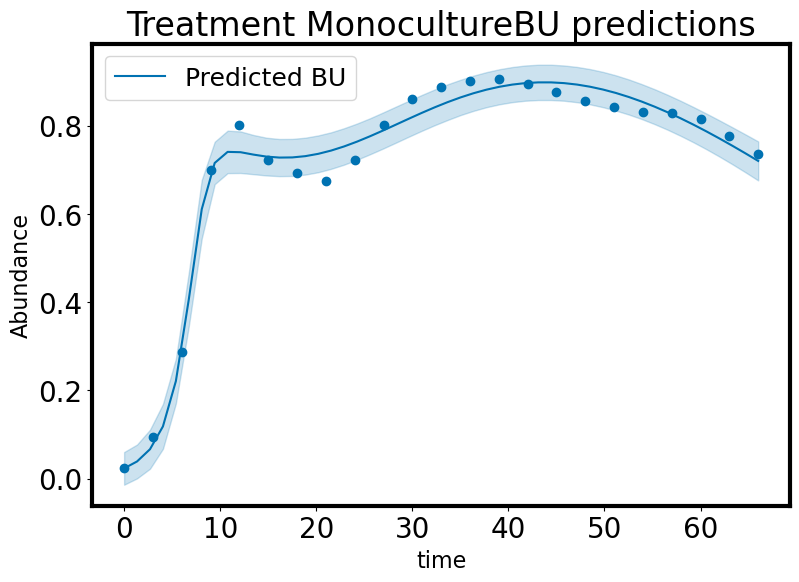

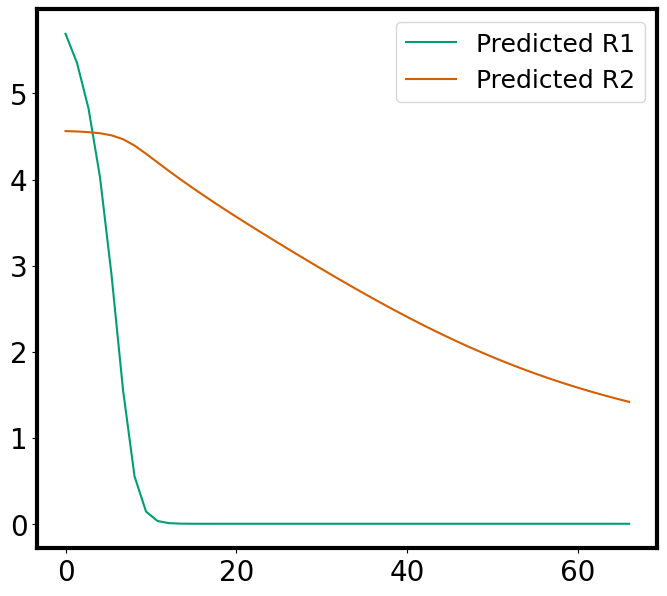

In [9]:
plot(model, BT_data)

In [10]:
r0 = model.params[:n_r]
r0

array([1.73940758, 1.51802439])

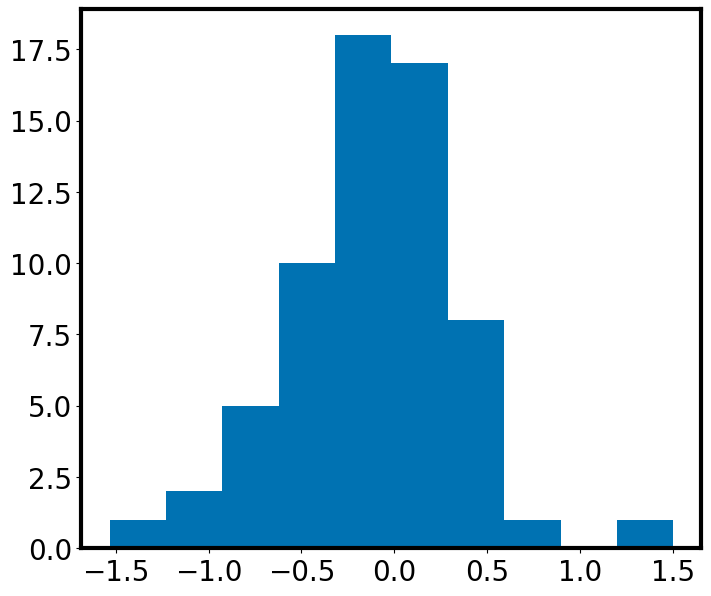

In [11]:
params = model.params[n_r:]
plt.hist(params)
plt.show()

In [13]:
# death rate
d = params[:n_s]
d

array([0.05185581])